**Preparing the Dataset**

 * The dataset folder is stored in my G-drive.
 * Download it and unpack it to the local folder.
 * Let us first locally install the required tools to unpack the compressed folders.

In [ ]:
!pip install patool
!pip install pyunpack
# Now download the compressed data folder
!gdown --id 1qqikjaX7tkfOONsF5EtR4vl6J7sToA6p
# uncompress it 
from pyunpack import Archive
Archive('HRC_WHU dataset.rar').extractall('/content')

     |████████████████████████████████| 81kB 7.4MB/s 


Downloading...
From: https://drive.google.com/uc?id=1qqikjaX7tkfOONsF5EtR4vl6J7sToA6p
To: /content/HRC_WHU dataset.rar
177MB [00:02, 66.2MB/s]


* Now the dataset folder contains both images and corresponding masks.
* For our convenience, we separate the images and masks and kept it in a separate folder.
* Let us write a piece of code to do that

In [ ]:
import os
import glob

In [ ]:
imgpath= []
suffix = 'ReferenceMask.tif' # 
for name in glob.glob('/content/HRC_WHU/*.tif'): 
    
    if name.endswith(suffix): # check whether the path represents an image or its mask
        continue
    imgpath.append(name) 
print('The number of images are: ',len(imgpath))

The number of images are:  150


In [ ]:
# Create a separate folder for images and masks
os.makedirs('/content/data/images')
os.makedirs('/content/data/masks')

In [ ]:
from tifffile import imread,imwrite
import numpy as np

In [ ]:
# Recursively read the image and masks and store them in their respective folder
# The image name and mask name are renamed with a corresponding index number.
index = 0
verbose = False
for path in imgpath:
    img = imread(path)
    
    if img.shape != (720,1280,3):
        img = np.resize(img,(720,1280,3))
    if verbose:
        print('Image Path:',path)
    imwrite('/content/data/images/'+str(index)+'.tif',data=img)
    # Append the mask name to the image path   
    maskpath = path.split('.')[0]+'_'+suffix
    if verbose:
        print('Mask Path:',maskpath)
    img_mask = imread(maskpath)
    if img_mask.shape != (720,1280):
        img_mask = np.resize(img_mask,(720,1280))
    imwrite('/content/data/masks/'+str(index)+'.tif',data=img_mask)
    
    index +=1
    

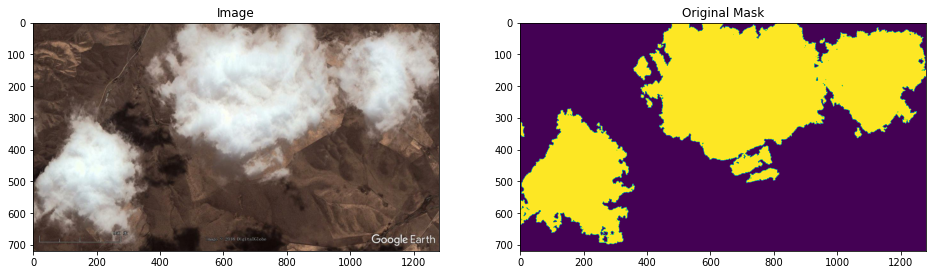

In [ ]:
# Display a sample image and its respective mask
from matplotlib import pyplot as plt
plt.figure(figsize=(16,12))
img = imread(imgpath[49])
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Image')
plt.subplot(1,2,2)
mask = imread('/content/data/masks/49.tif')
plt.imshow(mask)
plt.title('Original Mask')
plt.show()

**FCNN - UNET**
 * Now our data is ready.
 * We can create a U-Net Architecture and train it.
 * The skelton of the architecture is already available in Github. (Search before you start from the scartch :-)) 
 * Let us use it for our purpose by slightly modifying the settings.

In [ ]:
! git clone  https://github.com/milesial/Pytorch-UNet.git
! rm -r '/content/Pytorch-UNet/data'
! cp -r '/content/data' '/content/Pytorch-UNet/data'

Cloning into 'Pytorch-UNet'...
remote: Enumerating objects: 352, done.
remote: Total 352 (delta 0), reused 0 (delta 0), pack-reused 352
Receiving objects: 100% (352/352), 47.35 MiB | 13.36 MiB/s, done.
Resolving deltas: 100% (178/178), done.


In [ ]:
# change the working directory
os.chdir('/content/Pytorch-UNet')

In [ ]:
# Import all necessary modules
import logging
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

from eval import eval_net
from unet import UNet

from torch.utils.tensorboard import SummaryWriter
from utils.dataset import BasicDataset
from torch.utils.data import DataLoader, random_split

In [ ]:
dir_img = 'data/images/'
dir_mask = 'data/masks/'
dir_checkpoint = 'checkpoints/'

In [ ]:
# The model is set to run on a GPU
def train_net(net,
              device,
              epochs=5,
              batch_size=1,
              lr=0.001,
              val_percent=0.1,
              save_cp=True,
              img_scale=0.5):

    dataset = BasicDataset(dir_img, dir_mask, img_scale)
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train, val = random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

    writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')
    global_step = 0

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {lr}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_cp}
        Device:          {device.type}
        Images scaling:  {img_scale}
    ''')

    optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)
    if net.n_classes > 1:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        net.train()

        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                imgs = batch['image']
                true_masks = batch['mask']
                assert imgs.shape[1] == net.n_channels, \
                    f'Network has been defined with {net.n_channels} input channels, ' \
                    f'but loaded images have {imgs.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                imgs = imgs.to(device=device, dtype=torch.float32)
                mask_type = torch.float32 if net.n_classes == 1 else torch.long
                true_masks = true_masks.to(device=device, dtype=mask_type)

                masks_pred = net(imgs)
                loss = criterion(masks_pred, true_masks)
                epoch_loss += loss.item()
                writer.add_scalar('Loss/train', loss.item(), global_step)

                pbar.set_postfix(**{'loss (batch)': loss.item()})

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_value_(net.parameters(), 0.1)
                optimizer.step()

                pbar.update(imgs.shape[0])
                global_step += 1
                if global_step % (n_train // (10 * batch_size)) == 0:
                    for tag, value in net.named_parameters():
                        tag = tag.replace('.', '/')
                        writer.add_histogram('weights/' + tag, value.data.cpu().numpy(), global_step)
                        writer.add_histogram('grads/' + tag, value.grad.data.cpu().numpy(), global_step)
                    val_score = eval_net(net, val_loader, device)
                    scheduler.step(val_score)
                    writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], global_step)

                    if net.n_classes > 1:
                        logging.info('Validation cross entropy: {}'.format(val_score))
                        writer.add_scalar('Loss/test', val_score, global_step)
                    else:
                        logging.info('Validation Dice Coeff: {}'.format(val_score))
                        writer.add_scalar('Dice/test', val_score, global_step)

                    writer.add_images('images', imgs, global_step)
                    if net.n_classes == 1:
                        writer.add_images('masks/true', true_masks, global_step)
                        writer.add_images('masks/pred', torch.sigmoid(masks_pred) > 0.5, global_step)

        if save_cp:
            try:
                os.mkdir(dir_checkpoint)
                logging.info('Created checkpoint directory')
            except OSError:
                pass
            torch.save(net.state_dict(),
                       dir_checkpoint + f'CP_epoch{epoch + 1}.pth')
            logging.info(f'Checkpoint {epoch + 1} saved !')

    writer.close()

In [ ]:
# Instantiate the model
net = UNet(n_channels=3, n_classes=1, bilinear=True)

In [ ]:
# Check the availability of GPU
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logging.info(f'Using device {device}')

INFO: Using device cuda


In [ ]:
# Move the model to GPU and run it for just an epoch
net.to(device=device)
train_net(net=net,
                  epochs=1,
                  batch_size=2,
                  lr=0.0001,
                  device=device,
                  img_scale=1,
                  val_percent=0.2)

INFO: Creating dataset with 150 examples
INFO: Starting training:
        Epochs:          1
        Batch size:      2
        Learning rate:   0.0001
        Training size:   120
        Validation size: 30
        Checkpoints:     True
        Device:          cuda
        Images scaling:  1
    
Validation round: 100%|██████████| 15/15 [00:04<00:00,  3.83batch/s]
                                                                    INFO: Validation Dice Coeff: 0.0014400917383567246
Validation round: 100%|██████████| 15/15 [00:04<00:00,  3.85batch/s]
                                                                    INFO: Validation Dice Coeff: 5.436090408712328e-06
Validation round: 100%|██████████| 15/15 [00:04<00:00,  3.86batch/s]
                                                                    INFO: Validation Dice Coeff: 0.7109116991360982
Validation round: 100%|██████████| 15/15 [00:04<00:00,  3.85batch/s]
                                                                    I

In [ ]:
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from unet import UNet


In [ ]:
def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5):
    net.eval()
    full_img = Image.fromarray(full_img)
    img = torch.from_numpy(BasicDataset.preprocess(full_img, scale_factor))

    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)
        

        if net.n_classes > 1:
            probs = F.softmax(output, dim=1)
            
        else:
            probs = torch.sigmoid(output)
            

        probs = probs.squeeze(0)

        tf = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(full_img.size[1]),
                transforms.ToTensor()
            ]
        )

        probs = tf(probs.cpu())
        full_mask = probs.squeeze().cpu().numpy()

    return full_mask > out_threshold

Let us see how well the model perofrms on a trained image.

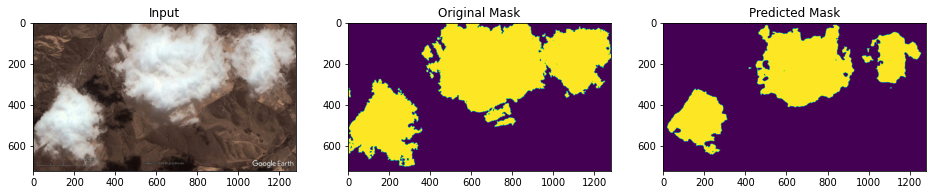

In [ ]:
plt.figure(figsize=(16,12))
img = imread(imgpath[49])
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Input')
plt.subplot(1,3,2)
mask = imread('/content/data/masks/49.tif')
plt.imshow(mask)
plt.title('Original Mask')
plt.subplot(1,3,3)
plt.imshow(predict_img(net,img,device,out_threshold=0.8))
plt.title('Predicted Mask')
plt.show()

How well the model performs on the unseen Image?

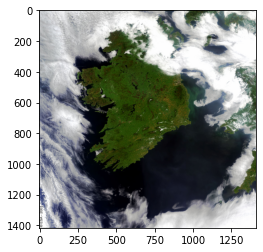

In [ ]:
# Let us download an image from Google Images
import requests
from io import BytesIO
response = requests.get("https://seos-project.eu/marinepollution/images/meris_ireland_clouds.jpg")
img = Image.open(BytesIO(response.content))
img = np.array(img)
plt.imshow(img)
plt.show()

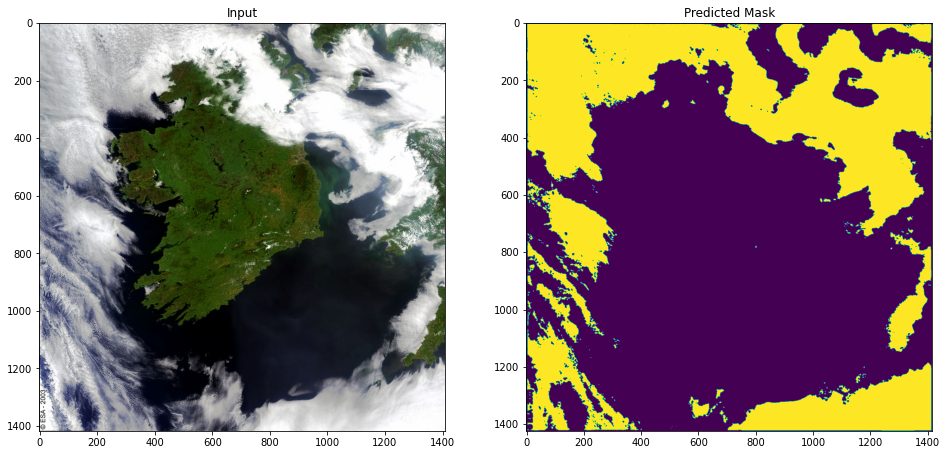

In [ ]:
plt.figure(figsize=(16,12))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Input')
plt.subplot(1,2,2)
plt.imshow(predict_img(net,img,device,out_threshold=0.8))
plt.title('Predicted Mask')
plt.show()